We'll start simple. So simple you may wonder if it's AI at all. When building models from scratch, I like to start with the easiest thing possible and iterate. Before we write any code, let's define what machine learning and machine learning models are.

## What is machine learning?

Machine learning is a field of artificial intelligence focused on algorithms that 1) learn from data and 2) generalize to unseen data. There are three main components to machine learning, data, models, and algorithms. Machine learning models are the things that do the learning and the algorithms direct the models learning. The lines blur at times between models and algorithms and some algorithms only work for some models. At their core, models are functions. They take an input, process them in some way, and return an output. Models have learnable parameters and machine learning algorithms focus on adjusting these parameters to make the model produce better outputs.

Conceptually, models are simple. Take the equation for a line, `f(x) = m*x + b`. This is a model where `m` and `b` are constant values indicating the slope and y-intercept of the line. `x` is an input value and the output is `f(x) = y`. If we know `m` and `b` we can compute `y` for any `x`. If we don't know `m` and `b`, this is where machine learning comes in. Assuming we have a bunch of `(x, y)` points, a machine learning algorithm can guess what good values for `m` and `b` are based on those points. Then we freeze those values and the model can predict `y` for any `x`.

Models can be giant equations and it's easy to get lost in the details, but remember _it's still just an equation!_ The learning algorithm will find the right constant terms for us. It's our job to set up the problem for the algorithm and model and then get out of the way so the machine can learn.

::: {.callout-note}
In machine learning, the constant terms of the equation are called parameters or weights. During training they are not constant as the learning algorithm is trying to find their optimal values, but once training is done these values become constant and you're left with a normal equation.
:::

### The learning process

At it's core the learning process iterates through prediction, comparison, and tweaking the model parameters. The training data is used in this process. We initialize the model, then use it as is to predict the outputs on the training data. These outputs are compared to the actual outputs, or targets, of the training data. If we are happy with the comparison training is done. Otherwise the model parameters are adjusted and the process begins again. This whole process is outlined below.

```{mermaid}
flowchart TB
  B[Predict output for train data] --> C[Compare predictions to targets]
  C --> D{Predictions good enough?}
  D -- No --> E[Update model weights]
  D -- Yes --> F[Freeze model for production]
  E --> B
```

## The simplest of models

Turning our attention back to our model, the simplest thing we can do is predict the same thing for every input. This may seem silly, but it gives us a measuring stick to compare to other models. If we use the latest and greatest techniques in deep learning, it should outperform this model. The only way we'll know it outperforms it is by building the model and testing it. If it doesn't outperform this model, that raises cause for concern and the results should be investigated. So we start simple and incrementally improve until we are satisfied.

### Train vs. test datasets

Now that we have a model in mind, we need to train it and test it. While training a model is the fun part, that's not really what we care about. We want to know how well our model works which is why we have a test set. The test set is used exclusively to benchmark the performance of the model and is not used in the training process. This comes back to making models that generalize to unseen data. Models generally perform better on data they're trained on because that data is what the model is optimized to predict for. If we use that same data to test the model, then we'll likely be overconfident in our models predictions. When we deploy the model and it is used on new data it hasn't seen we'll be in for a rude awakening. So we separate our dataset into training and testing datasets. In practice care should go into how these datasets are curated[I highly recommend this [blog post](https://www.fast.ai/posts/2017-11-13-validation-sets.html) on the dangers of blindly splitting your data. It is about validation sets, but the same concepts apply to test sets. It's ok if some of the content is over your head as we'll revisit this in a later chapter.]{.aside}, but we won't worry about that here since I've already cleaned our datasets.

Let's train our model to always predict the most common label in the train set and predict the labels of the test set.

In [1]:
import numpy as np
from nlpbook import get_train_test_data

train_df, test_df = get_train_test_data()
y_train = train_df["label"]
y_test = test_df["label"]
predicted_output = y_train.value_counts().idxmax()
# `predicted_output` is the most common label in the train set.
pred = np.full(len(y_test), predicted_output)
pred

array([1, 1, 1, ..., 1, 1, 1])

Our predictions on the test set are all `1` because that's the most common label in the train set. We will refer to this model as `BaselineClassifier`. Let's wrap this up in a class for ease of training and prediction.

In [2]:
class BaselineClassifier:
    def fit(self, X, y):
        """Train the model with inputs `X` on labels `y`."""
        # Here we use `numpy` instead of `pandas` since the
        # input can be any ordered container type.
        labels, counts = np.unique(y, return_counts=True)
        self.prediction = labels[np.argmax(counts)]
        return self

    def predict(self, X):
        """Predict the labels for inputs `X`."""
        return np.full(len(X), self.prediction)


bf = BaselineClassifier()
bf.fit(train_df, y_train)
(bf.predict(test_df) == pred).all()

np.True_

The `fit` method is where the model is trained. This is common lingo in machine learning. We are "fitting" a model to data. Then we predict labels for unseen data with the `predict` method. When crafting models, best practices are to allow multiple inputs at once. This has two benefits, 1) we only need to make one function call, and 2) we can take advantage of high performance libraries (like `numpy`) to more quickly train and predict. Our `fit` and `predict` methods accept `N` data points and leverage `numpy` for speed.

Now, how do we measure this model's performance?

## Metrics, metrics, metrics

Metrics give a sense of how well your model is doing. They allow you to measure and compare models against the same test set. There is no one size fits all metric, and you'll usually want to look at multiple metrics when evaluating models. I recommend starting with the end when picking metrics. Why are you building this model in the first place? What is it you want the model to do? Then define your metrics with that objective in mind.

### Accuracy

We are trying to predict the sentiment of movie reviews. We don't care about positive vs negative, we just care that we get it right. It's a simple question, "How many predictions are correct?" This is accuracy. It's measured as a ratio, the correct predictions over all predictions.

In [3]:
def accuracy(y, y_pred):
    y, y_pred = np.array(y), np.array(y_pred)
    return np.sum(y == y_pred) / len(y)

Metrics don't have to be complicated, and it really just takes one line of Python to calculate. Let's check the accuracy of our model.

In [4]:
accuracy(y_test, pred)

np.float64(0.5011190233977619)

Our accuracy is `0.5` out of `1.0`, which means we got half of the predictions correct. This makes sense since our dataset is half positive and half negative labels, so if we predict `1` for everything we should get half of them correct.

#### Imbalance datasets and accuracy

Metrics are not foolproof. What is "good" for one dataset may not be for another. This is why we start with the simplest possible model(s). Because it allows us to establish minimum benchmarking values to compare against. Let's run through an example to show how accuracy changes with the ratio of positive to negative labels in the dataset using our simple models.

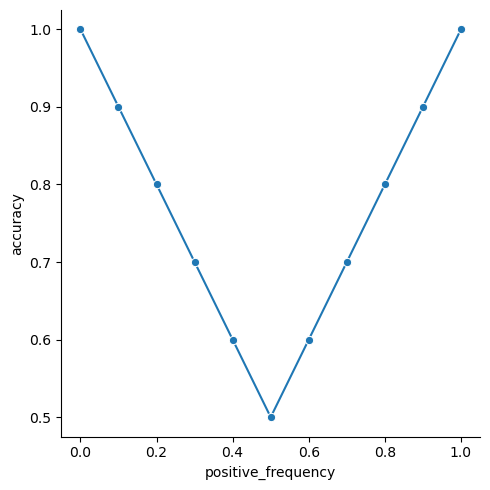

In [5]:
# | echo: false
import pandas as pd
import seaborn as sns


def plot_metric(metric_fn):
    metric_label = metric_fn.__name__
    model = BaselineClassifier()
    data = []
    for i in range(0, 101, 10):
        labels = [1] * i + [0] * (100 - i)
        model.fit(labels, labels)
        y_test = labels
        data.append(
            {
                "positive_frequency": i / 100,
                metric_label: metric_fn(y_test, model.predict(y_test)),
            }
        )

    sns.relplot(
        pd.DataFrame(data),
        x="positive_frequency",
        y=metric_label,
        kind="line",
        markers=True,
        marker="o",
    )


plot_metric(accuracy)

The accuracy of our model is `0.5` when we have a 50/50 ratio of positive to negative labels. As the ratio moves to either extreme however (all ones or all zeros), the accuracy goes up until it reaches `1.0` when all the labels in the dataset are the same.

Intuitively a higher accuracy is better, but it might not be high because your model works well. It could be that your dataset is imbalanced and your model has figured that out and predicts everything to be the majority class. In that scenario, you end up with a fancy model you put all this effort into just to get the same result as the simple model we just made. How do you combat this? By doing what we've done here and start with a simple model. Then as you develop more complex models, they can be compared to this simple model to see if they make improvements.

### Other metrics

Accuracy is not the only thing we can measure, but for simplicities sake it will be the only thing we measure in this book. Other metrics we could look at are F1-score and Matthews Correlation Coefficient (MCC).

## scikit-learn

`scikit-learn` is a widely used machine learning library. It also provides a framework to integrate your own machine learning models to leverage all the bells and whistles of `scikit-learn`. One such benefit is benchmarking. `scikit-learn` models come with a `score` method, and the default `score` method for classifiers is accuracy. By wrapping our model in `scikit-learn`s framework, we get accuracy scores for free.

### scikit-learn best practices

There's a [pretty lengthy document](https://scikit-learn.org/stable/developers/develop.html) on developing `scikit-learn` models, but most of the advice on that page can be boiled down to a few points.

- `__init__` is for setting attributes, not computation.
- Every parameter for `__init__` should have a corresponding attribute.
- Computation during training that needs to persist across method calls should be assigned to attributes with an underscore suffix.
- The `fit` method is for training and the `predict` method is for prediction.
- `fit` should return `self`.
- Must accept `N` data points at once.
- `BaseEstimator` should be to the right of `scikit-learn` mixins.

With a few tweaks, our `BaselineClassifier` becomes a `scikit-learn` model.

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin


class BaselineClassifier(ClassifierMixin, BaseEstimator):
    def fit(self, X, y):
        """Train the model with inputs `X` on labels `y`."""
        labels, counts = np.unique(y, return_counts=True)
        self.prediction_ = labels[np.argmax(counts)]
        return self

    def predict(self, X):
        """Predict the labels for inputs `X`."""
        return np.full(len(X), self.prediction_)


cls = BaselineClassifier().fit(train_df, y_train)
cls.score(test_df, y_test)

0.5011190233977619

And with that we get accuracy for free. Thanks `scikit-learn`.

Turns out `scikit-learn` provides this model already as `sklearn.dummy.DummyClassifier`.

In [7]:
from sklearn.dummy import DummyClassifier

cls = DummyClassifier().fit(train_df, y_train)
cls.score(test_df, y_test)

0.5011190233977619

## Bonus: multiclass classification

Up to this point we've dealt with binary classification, the label is either `0` or `1`, but classification can extend to 3 or more labels. Our dataset includes ratings which we can use as multiclass labels. Fortunately, we've written `BaselineClassifier` to work on an arbitrary number of labels, so we should get multiclass classification for free. Let's see what happens when we use the `rating` column instead of the `label` column.

In [8]:
cls = BaselineClassifier().fit(train_df, train_df["rating"])
cls.score(test_df, test_df["rating"])

0.1997151576805697

At first glance this may seem low, but if you take a second to think about it, it actually makes sense. As the number of unique labels goes up, the frequency of the majority label is more likely to go down. Let's look at the breakdown of ratings frequency.

In [9]:
train_df.groupby("rating").size() / len(train_df)

rating
1     0.203501
2     0.091230
3     0.096852
4     0.107613
7     0.100104
8     0.120704
9     0.090548
10    0.189447
dtype: float64

Here we see the most frequent label shows up 20% of the time, which is inline with our accuracy on the test set. Good thing we have a baseline model to orient us as we think about accuracy on binary and multiclass classification problems!